***Rigid Body Test***

Free fall test, and force measurement of rigid bodies with default simulation properties

In [2]:
from isaacsim import SimulationApp
simulation_app = SimulationApp({"headless": False})

# Force startup in paused mode
simulation_app.set_setting("/physics/autoStart", False)
simulation_app.set_setting("/app/runSim", False)


import numpy as np
import matplotlib.pyplot as plt
import csv, time, os
from datetime import datetime

from isaacsim.core.api import World
from isaacsim.core.api.objects import DynamicSphere, FixedCuboid
from isaacsim.core.prims import RigidPrim
from pxr import UsdGeom, UsdPhysics
import omni.ui as ui


Starting kit application with the following args:  ['/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/exts/isaacsim.simulation_app/isaacsim/simulation_app/simulation_app.py', '/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/apps/isaacsim.exp.base.python.kit', '--/app/tokens/exe-path=/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/kit', '--/persistent/app/viewport/displayOptions=3094', '--/rtx/materialDb/syncLoads=True', '--/rtx/hydra/materialSyncLoads=True', '--/omni.kit.plugin/syncUsdLoads=True', '--/app/renderer/resolution/width=1280', '--/app/renderer/resolution/height=720', '--/app/window/width=1440', '--/app/window/height=900', '--/renderer/multiGpu/enabled=True', '--/app/fastShutdown=False', '--/app/installSignalHandlers=0', '--ext-folder', '/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/exts', '--ext-folder', '/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/apps', '

2025-12-09T17:30:51Z [6,416ms] [Error] [asyncio] Exception in callback _patch_task.<locals>.step()
handle: <Handle _patch_task.<locals>.step()>
Traceback (most recent call last):
  File "/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/kit/python/lib/python3.11/asyncio/events.py", line 84, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x73ce9c7d2180> is already entered
2025-12-09T17:30:52Z [7,290ms] [Error] [asyncio] Task was destroyed but it is pending!
task: <Task pending name='Task-165' coro=<_async_in_context.<locals>.run_in_context() done, defined at /home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/kit/python/lib/python3.11/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-166' coro=<Kernel.shell_main() running at /home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/kit/python/lib/python3.11/site-packages/ipykernel/kern

[7.301s] Simulation App Startup Complete
⏵ Waiting for PLAY...
⏹ STOP detected — test ended
📈 Plot saved → sphere_compression_20251210_023112_disp.png
⏱️ Plot saved → sphere_compression_20251210_023112_time.png


### Simulation parameters

In [9]:
DT = 1/60.0
SPHERE_RADIUS = 0.10
BLOCK_SIZE = 0.5
TEST_NAME = "sphere_compression"
TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

CSV_FILE = f"{TEST_NAME}_{TIMESTAMP}.csv"
PLOT_FILE = f"{TEST_NAME}_{TIMESTAMP}.png"

running = False   # UI-controlled flag
disp_log = []
force_log = []


### GUI Panel

In [10]:
def create_world():
    world = World(stage_units_in_meters=1.0)
    stage = world.stage
    world.scene.add_default_ground_plane()
    return world, stage


def create_fixed_block(world):
    return world.scene.add(
        FixedCuboid(
            prim_path="/FixedBlock",
            name="fixed_block",
            position=np.array([0, 0, BLOCK_SIZE/2]),
            size=BLOCK_SIZE,
            color=np.array([255, 0, 0])
        )
    )


def create_dynamic_sphere(world):
    return world.scene.add(
        DynamicSphere(
            prim_path="/Sphere",
            name="sphere",
            position=np.array([0, 0, 1.0]),
            radius=SPHERE_RADIUS,
            color=np.array([255, 255, 0]),
            mass=1.0
        )
    )


### World and Geometry Creation 

In [11]:
def create_prismatic_joint(stage):
    joint = UsdPhysics.PrismaticJoint.Define(stage, "/World/JointZ")
    joint.CreateAxisAttr("Z")
    joint.CreateLowerLimitAttr(0.0)
    joint.CreateUpperLimitAttr(1.5)

    # static reference frame
    xform = UsdGeom.Xform.Define(stage, "/World/Ref")
    joint.CreateBody0Rel().SetTargets(["/World/Ref"])

    joint.CreateBody1Rel().SetTargets(["/Sphere"])

    drive = UsdPhysics.DriveAPI.Apply(joint.GetPrim(), "linear")
    drive.CreateTypeAttr().Set("position")
    drive.CreateStiffnessAttr().Set(40000)
    drive.CreateDampingAttr().Set(5000)
    return drive


def create_contact_view(world):
    view = RigidPrim(
        prim_paths_expr="/Sphere",
        contact_filter_prim_paths_expr=["/FixedBlock"],
        name="contact_view",
        max_contact_count=32,
    )
    world.scene.add(view)
    return view


In [12]:
def start_test():
    global running, disp_log, force_log
    running = True
    disp_log.clear()
    force_log.clear()
    print("▶ Test started.")


def stop_test():
    global running
    running = False
    print("⏹ Test stopped — data ready.")

### Simulation Loop

In [13]:
def run_test(world, drive, contact_view, sphere):
    time_log = []
    disp_log = []
    force_log = []

    target = 0.2
    direction = -1
    sim_time = 0.0

    print("⏵ Waiting for PLAY...")

    while simulation_app.is_running():

        if world.is_playing():

            # --- time ----------
            sim_time += DT
            time_log.append(sim_time)

            # --- displacement command ----------
            target += 0.001 * direction

            if target <= 0.35:
                direction = +1
            elif target >= 1.0:
                direction = -1

            drive.GetTargetPositionAttr().Set(target)

            # --- ACTUAL SPHERE POSITION (feedback) ----------
            sphere_pos = sphere.get_world_pose()[0][2]  # z coordinate
            disp_log.append(sphere_pos)

            # --- contact force ----------
            result = contact_view.get_contact_force_data(dt=DT)
            if result:
                forces, _, normals, *_ = result
                fn = float(np.sum(forces * normals)) if forces.shape[0] else 0.0
            else:
                fn = 0.0

            force_log.append(fn)

        if world.is_stopped() and len(time_log) > 3:
            print("⏹ STOP detected — test ended")
            return time_log, disp_log, force_log

        world.step(render=True)


### Data Logging

In [14]:
def save_csv(time, disp, force, tag="default"):
    """
    Save Force–Displacement–Time data to CSV using a naming tag.
    Example: tag="sphere_test" → sphere_test_data.csv
    """
    filename = f"{tag}_compression_data.csv"

    with open(filename, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["time_s", "displacement_m", "normal_force_N"])

        for t, d, fn in zip(time, disp, force):
            writer.writerow([t, d, fn])

    print(f"🧾 CSV saved → {filename}")
    return filename



def save_plot(time, disp, force):
    # ---- Plot 1: Force vs Displacement ----
    plt.figure(figsize=(7,4))
    plt.plot(disp, force, linewidth=2)
    plt.xlabel("Sphere Displacement (m)")
    plt.ylabel("Normal Force (N)")
    plt.title("Sphere Compression — Force vs Displacement")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(PLOT_FILE.replace(".png", "_disp.png"), dpi=300)
    print("📈 Plot saved →", PLOT_FILE.replace(".png", "_disp.png"))
    plt.show()

    # ---- Plot 2: Force vs Time ----
    plt.figure(figsize=(7,4))
    plt.plot(time, force, linewidth=2)
    plt.xlabel("Time (s)")
    plt.ylabel("Normal Force (N)")
    plt.title("Sphere Compression — Force vs Time")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(PLOT_FILE.replace(".png", "_time.png"), dpi=300)
    print("⏱️ Plot saved →", PLOT_FILE.replace(".png", "_time.png"))
    plt.show()


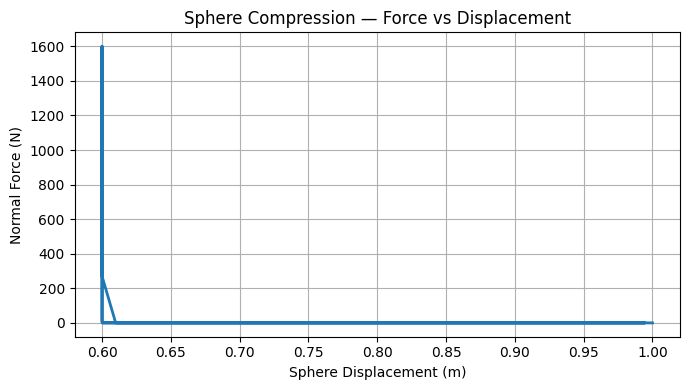

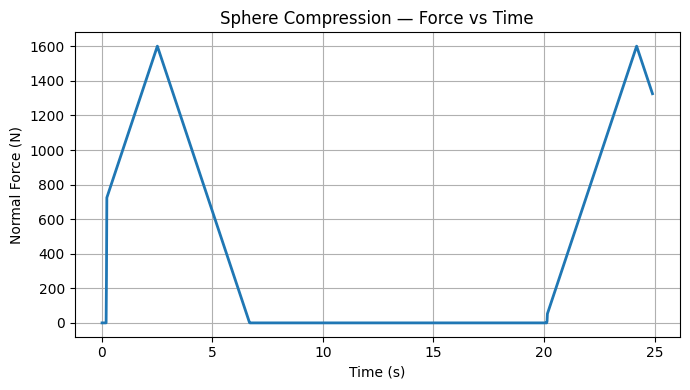

In [15]:
world, stage = create_world()
create_fixed_block(world)
sphere = create_dynamic_sphere(world)
drive = create_prismatic_joint(stage)
contact_view = create_contact_view(world)
world.reset()
time, disp, force = run_test(world, drive, contact_view,sphere)
# save_csv(time, disp, force)
save_plot(time, disp, force)


In [ ]:
simulation_app.close()